# Custom Corolectal Cancer Pre-trained Model

### This notebook contains the implementation for the first pre-trained CNN encoder outlined as the first task of the project proposal. The architecture selected is ResNet and the implementation used comes from the `torchvision` module.

### Below are 4 different attempts at pre-training the model to find the ideal loop, optimizer and loss function that will yield the best performance for the model. The following 4 optimizers were selected.
- #### **SGD**
- #### **SGD + Momentum**
- #### **RMSProp**
- #### **Adam**

### Each loop utilizes the Categorical cross Entropy (CCE) loss function due to the presence of 3 distinct classes in the dataset (MUS, NORM, STR)

#### Initializations

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import resnet50
from sklearn.manifold import TSNE
from enum import Enum

class optimizer_choice(Enum):
    SGD = 0
    MOMENTUM = 1
    RMSPROP = 2
    ADAM = 3

print(f"torch.cuda.is_available(): {torch.cuda.is_available()}")

torch.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# [Task 1]: Import and initialize ResNet50
resnet_corolectal_cancer_model = resnet50(weights=None, num_classes=3)
'''
Note that by default the ResNet implementations from PyTorch's source code follow the ImaegNet fully connected layer specification of 2048x1000.
    Therefore, for our project, we need to change it to use 3 classes according to the first dataset (MUS, NORM, STR).
    See the source code for the base class here (https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py).
    Stack Overflow post here (https://stackoverflow.com/questions/68980724/the-number-of-classes-in-pytorch-pretrained-model).

    Additionally, we will need to remove the last layer to be able to pass the features to a different learning algorithm in task 2.
    Here is a Stack Overflow post about it (https://stackoverflow.com/questions/52548174/how-to-remove-the-last-fc-layer-from-a-resnet-model-in-pytorch).

'''
# resnet_corolectal_cancer_model.fc = nn.Linear(2048, 3)
resnet_corolectal_cancer_model.to(device=device)
resnet_corolectal_cancer_model.train()

# [Task 1]: Import and initialize the optimizer algorithms
'''
Hyperparameters for vanilla SGD recommended settings: learning rate = 0.001
                                                      L2 regularizer penalty = 1e-6
                                                      Batch Size = 100
'''
learning_rate = 0.001
l2_regularizer = 1e-6
batch_size = 32
num_epochs = 5 

sgd_no_momentum = optim.SGD(resnet_corolectal_cancer_model.parameters(), lr=learning_rate, weight_decay=l2_regularizer)

'''
Hyperparameters for SGD + momentum recommended settings: learning rate = 0.001
                                                         L2 regularizer penalty = 1e-6
                                                         Batch Size = 100
                                                         Momentum = 0.9
                                                         Nesterov = true
'''
momentum_term = 0.9
sgd_momentum_use_nesterov = True

momentum = optim.SGD(resnet_corolectal_cancer_model.parameters(),
                            lr=learning_rate,
                            weight_decay=l2_regularizer,
                            momentum=momentum_term,
                            nesterov=sgd_momentum_use_nesterov)

'''
Hyperparameters for Adam recommended settings: learning rate = 0.001
                                               L2 regularizer penalty = 1e-6
                                               Batch Size = 100
                                               Beta 1 (Momentum) = 0.9
                                               Beta 2 (RMS decay rate) = 0.999
                                               Division stablizer = 1e-8
'''
adam_betas = (0.9, 0.999)
epsilon_division_stablizer = 1e-8

adam = optim.Adam(resnet_corolectal_cancer_model.parameters(),
                    lr=learning_rate,
                    weight_decay=l2_regularizer,
                    betas=adam_betas,
                    eps=epsilon_division_stablizer)

'''
Hyperparameters for RSMProp recommended settings: learning rate = 0.001
                                                  L2 regularizer penalty = 1e-6
                                                  Batch Size = 100
                                                  Decay rate = 0.999
                                                  Division stablizer = 1e-8
'''
rmsprop_decay_rate = adam_betas[1]

rmsprop = optim.RMSprop(resnet_corolectal_cancer_model.parameters(),
                        lr=learning_rate,
                        weight_decay=l2_regularizer,
                        alpha=rmsprop_decay_rate,
                        eps=epsilon_division_stablizer)

# [Task 1]: Import and initialize the t-SNE visualization algorithm
tsne = TSNE(random_state=42)

torch.cuda.is_available(): True


In [2]:
def plot_model_result(_losses, _accuracies, _num_batches, _mode_name="Training", _optimizer_name="SGD", _dataset_name="Corolectal Cancer"):
    plt.style.use('seaborn-v0_8-dark')

    fig, (momentum_loss_ax, momentum_acc_ax) = plt.subplots(1, 2, figsize=(16,6))
    momentum_loss_ax.plot(np.arange(1, len(_losses) + 1), _losses)
    momentum_loss_ax.set_xlabel(f"Epoch (Minibatch size = {_num_batches}, Batch size = {batch_size})")
    momentum_loss_ax.set_xticks(np.arange(1, len(_losses) + 1))
    momentum_loss_ax.set_ylabel("CCE loss")
    momentum_loss_ax.set_title(f"{_mode_name} Epoch vs. Loss for {_dataset_name} Set ({_optimizer_name})")
    momentum_loss_ax.grid()

    momentum_acc_ax.plot(np.arange(1, len(_accuracies) + 1), _accuracies)
    momentum_acc_ax.set_xlabel(f"Epoch (Minibatch size = {_num_batches}, Batch size = {batch_size})")
    momentum_acc_ax.set_xticks(np.arange(1, len(_accuracies) + 1))
    momentum_acc_ax.set_ylabel("Accuracy (%)")
    momentum_acc_ax.set_yticks(np.arange(0, 110, 10))
    momentum_acc_ax.set_title(f"{_mode_name} Epoch vs. Accuracy for {_dataset_name} Set ({_optimizer_name})")
    momentum_acc_ax.grid()

    plt.show()


def do_model_epoch_loop(_model, _data_loader, _num_epochs, _optimizer, _is_training=True, _is_validation=False, _device="cpu", _show_plot=True, _optimizer_name="SGD", _dataset_name="Corolectal_Cancer"):
    epoch_losses = []

    epoch_accuracies = []

    if _is_training:
        _model.train()
    else:
        _model.eval()

    num_batches = len(_data_loader)

    for epoch in range(_num_epochs):  
        total_epoch_loss = 0.0  # Track loss for the epoch
        
        total_epoch_acc = 0.0  # Track accuracy for the epoch

        for inputs, labels in _data_loader:
            inputs, labels = inputs.to(_device), labels.to(_device) 

            _optimizer.zero_grad() 
            
            outputs = _model(inputs)  # Forward pass
            loss = nn.CrossEntropyLoss()(outputs, labels)  # Calculate loss
            if _is_training:
                loss.backward()  # Backward pass to compute gradients
            
                _optimizer.step()  # Update model parameters using gradients

            total_epoch_loss += loss.item()

            softmax_confidence_scores = F.softmax(outputs, dim=1)
            label_prediction = torch.argmax(softmax_confidence_scores, dim=1).view(-1)
            total_epoch_acc += ((label_prediction == labels).sum().item() / len(labels)) * 100

        epoch_losses.append(total_epoch_loss / num_batches)

        epoch_accuracies.append(total_epoch_acc / num_batches)

        print(f"[INFO] Epoch {epoch + 1}/{_num_epochs}, Loss: {epoch_losses[epoch]:.4f}, Accuracy: {epoch_accuracies[epoch]:.4f}%")

    if _show_plot:
        plot_model_result(epoch_losses, epoch_accuracies, num_batches, "Training" if _is_training else "Validation" if _is_validation else "Test", _dataset_name)

    if not _is_training and not _is_validation:
        state_dict = _model.state_dict()
        torch.save(state_dict, f"Models/ResNet_{_optimizer_name}_{_dataset_name}_pre_trained.tar")

        print("[INFO] Saved the pre-trained model!")

    return epoch_losses, epoch_accuracies


def load_data(_data_dir="Datasets/Corolectal Cancer/"):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet
        transforms.RandomHorizontalFlip(),  # Data augmentation
        transforms.ToTensor(),  
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet Normalization
    ])

    if not os.path.exists(_data_dir):
        raise FileNotFoundError(f"Dataset directory '{_data_dir}' does not exist.")

    full_dataset = datasets.ImageFolder(root=_data_dir, transform=transform)

    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    return train_dataset, test_dataset

#### Data Preprocessing

In [3]:
'''
Source(s):
    - Key Steps in Data Preprocessing: https://www.techtarget.com/searchdatamanagement/definition/data-preprocessing 
'''
# Optimizers
optimizer = optim.RMSprop(resnet_corolectal_cancer_model.parameters(), lr=learning_rate, weight_decay=l2_regularizer)

# Preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),  
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet Normalization
])

dataset_root = 'Datasets/Corolectal Cancer/'
if not os.path.exists(dataset_root):
    raise FileNotFoundError(f"Dataset directory '{dataset_root}' does not exist.")


full_dataset = datasets.ImageFolder(root=dataset_root, transform=transform)

# Data Profiling: Check number of classes and their album size
if len(full_dataset) == 0:
    raise ValueError("The dataset is empty. Please check the image files.")

num_classes = len(full_dataset.classes)
if num_classes == 0:
    raise ValueError("Classes Detected: FAILED")
else:
    print(f"[INFO] Classes Detected: {num_classes}, CHECK")

# Display full dataset size
class_counts = np.bincount(full_dataset.targets)
for i, count in enumerate(class_counts):
    print(f"\t> {full_dataset.classes[i]}: {count} samples")

# Data Cleansing: Conditions to meet otherwise discarded warning
min_samples = 5  
classes_to_remove = [full_dataset.classes[i] for i, count in enumerate(class_counts) if count < min_samples]
if classes_to_remove:
    print(f"[WARNING] Classes to remove due to low sample size: {classes_to_remove}")

# Data Validation: Split 80:20, DataLoaders for train/test
train_size = int(0.8 * len(full_dataset))  
test_size = len(full_dataset) - train_size  
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def check_dataloader(dataloader, name):
    try:
        inputs, labels = next(iter(dataloader))
        print(f"[INFO] {name} DataLoader is working: CHECK\n\t> Inputs size: {inputs.size()}, \n\t> Labels size: {labels.size()}")
    except Exception as e:
        raise RuntimeError(f"[ERROR] {name} DataLoader failed: {e}")

check_dataloader(train_dataloader, "Train")
check_dataloader(test_dataloader, "Test")

[INFO] Classes Detected: 3, CHECK
	> MUS: 2000 samples
	> NORM: 2000 samples
	> STR: 2000 samples
[INFO] Train DataLoader is working: CHECK
	> Inputs size: torch.Size([32, 3, 224, 224]), 
	> Labels size: torch.Size([32])
[INFO] Test DataLoader is working: CHECK
	> Inputs size: torch.Size([32, 3, 224, 224]), 
	> Labels size: torch.Size([32])


[INFO] Starting training w/SGD + Momentum... CHECK
[INFO] Epoch 1/5, Loss: 0.9247, Accuracy: 51.8333%
[INFO] Epoch 2/5, Loss: 0.5989, Accuracy: 72.2500%
[INFO] Epoch 3/5, Loss: 0.4657, Accuracy: 81.2083%
[INFO] Epoch 4/5, Loss: 0.4030, Accuracy: 83.7500%
[INFO] Epoch 5/5, Loss: 0.3561, Accuracy: 86.4583%
[INFO] Epoch 6/5, Loss: 0.3073, Accuracy: 87.6250%
[INFO] Epoch 7/5, Loss: 0.2877, Accuracy: 89.0833%
[INFO] Epoch 8/5, Loss: 0.2413, Accuracy: 91.0417%
[INFO] Epoch 9/5, Loss: 0.2328, Accuracy: 91.2708%
[INFO] Epoch 10/5, Loss: 0.2309, Accuracy: 91.0208%
[INFO] Epoch 11/5, Loss: 0.1972, Accuracy: 92.7708%
[INFO] Epoch 12/5, Loss: 0.1817, Accuracy: 92.3333%
[INFO] Epoch 13/5, Loss: 0.1468, Accuracy: 94.7917%
[INFO] Epoch 14/5, Loss: 0.1520, Accuracy: 94.1875%
[INFO] Epoch 15/5, Loss: 0.1369, Accuracy: 95.1458%
[INFO] Epoch 16/5, Loss: 0.1293, Accuracy: 95.0000%
[INFO] Epoch 17/5, Loss: 0.1142, Accuracy: 95.7083%
[INFO] Epoch 18/5, Loss: 0.1413, Accuracy: 94.8958%
[INFO] Epoch 19/5, Los

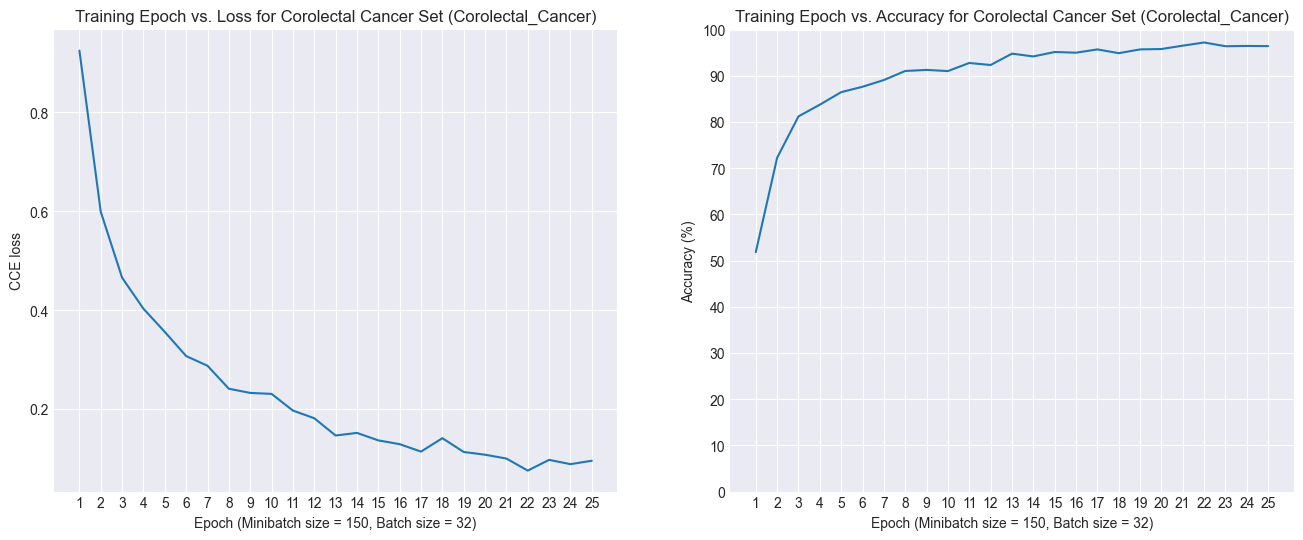

[INFO] Finished training w/SGD + Momentum!


In [4]:
# Training loop
print("[INFO] Starting training w/SGD + Momentum... CHECK")

do_model_epoch_loop(resnet_corolectal_cancer_model, train_dataloader, 25, momentum, _device=device)

print("[INFO] Finished training w/SGD + Momentum!")

[INFO] Begin inference on test set...
[INFO] Epoch 1/5, Loss: 0.1734, Accuracy: 94.8191%
[INFO] Epoch 2/5, Loss: 0.1699, Accuracy: 95.1480%
[INFO] Epoch 3/5, Loss: 0.1723, Accuracy: 94.7368%
[INFO] Epoch 4/5, Loss: 0.1594, Accuracy: 94.9836%
[INFO] Epoch 5/5, Loss: 0.1782, Accuracy: 94.4901%
[INFO] Epoch 6/5, Loss: 0.1671, Accuracy: 94.9013%
[INFO] Epoch 7/5, Loss: 0.1751, Accuracy: 94.5724%
[INFO] Epoch 8/5, Loss: 0.1627, Accuracy: 94.9836%
[INFO] Epoch 9/5, Loss: 0.1690, Accuracy: 94.9836%
[INFO] Epoch 10/5, Loss: 0.1627, Accuracy: 94.9013%


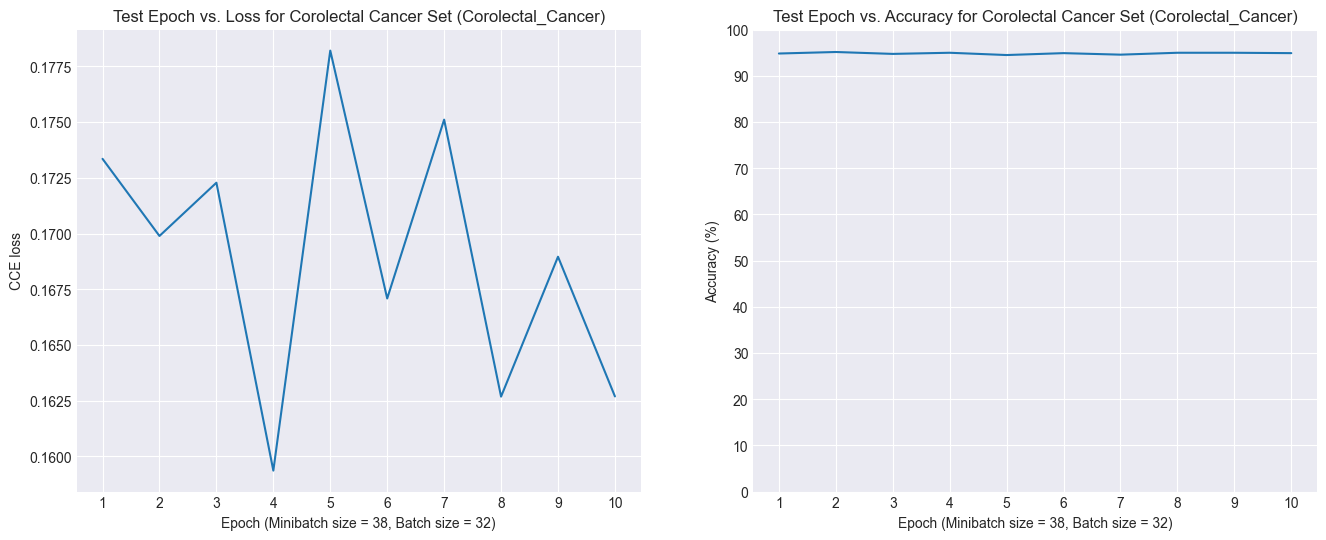

[INFO] Saved the pre-trained model!
[INFO] Finished training w/SGD + Momentum!


In [5]:
# Test set inference
print("[INFO] Begin inference on test set...")

do_model_epoch_loop(resnet_corolectal_cancer_model, test_dataloader, 10, momentum, _is_training=False, _device=device, _optimizer_name="Momentum")

print("[INFO] Finished training w/SGD + Momentum!")

#### RMSProp Optimizations

[INFO] Starting training... CHECK
[INFO] Epoch 1/5, Train Loss: 0.9312, Train Accuracy: 0.6985
[INFO] Epoch 1/5, Test Loss: 0.3737, Test Accuracy: 0.8592
[INFO] Epoch 2/5, Train Loss: 0.3956, Train Accuracy: 0.8363
[INFO] Epoch 2/5, Test Loss: 0.2726, Test Accuracy: 0.8958
[INFO] Epoch 3/5, Train Loss: 0.2841, Train Accuracy: 0.8873
[INFO] Epoch 3/5, Test Loss: 0.3154, Test Accuracy: 0.8692
[INFO] Epoch 4/5, Train Loss: 0.2237, Train Accuracy: 0.9140
[INFO] Epoch 4/5, Test Loss: 0.2646, Test Accuracy: 0.8975
[INFO] Epoch 5/5, Train Loss: 0.1732, Train Accuracy: 0.9381
[INFO] Epoch 5/5, Test Loss: 0.1504, Test Accuracy: 0.9508


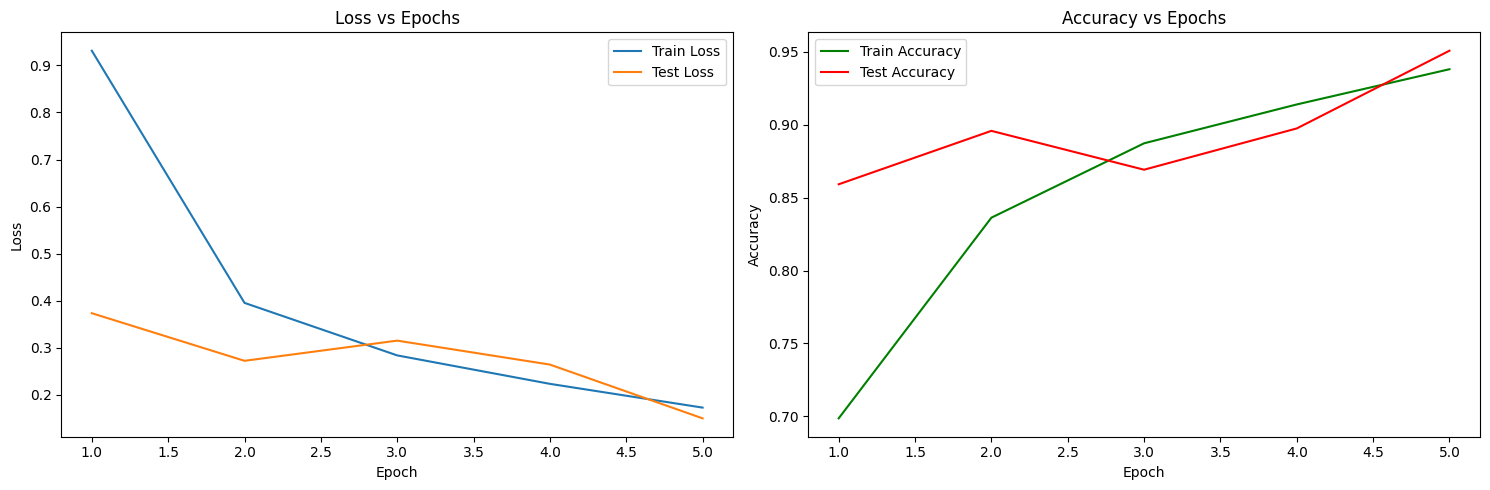

In [ ]:
optimizer = rmsprop

# Cosine Annealing scheduler for smooth learning rate adjustment ---> Prevents super overfitting data
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

print("[INFO] Starting training... CHECK")
for epoch in range(num_epochs):
    resnet_corolectal_cancer_model.train()
    total_train_loss, correct_train, total_train = 0.0, 0, 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass and loss computation
        outputs = resnet_corolectal_cancer_model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = correct_train / total_train

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"[INFO] Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Evaluation mode for test data
    resnet_corolectal_cancer_model.eval()
    total_test_loss, correct_test, total_test = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass and loss computation
            outputs = resnet_corolectal_cancer_model(inputs)
            loss = nn.CrossEntropyLoss()(outputs, labels)

            total_test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    avg_test_loss = total_test_loss / len(test_dataloader)
    test_accuracy = correct_test / total_test

    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)

    print(f"[INFO] Epoch {epoch + 1}/{num_epochs}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(15, 5))

# Plot 1: Loss vs Epochs
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

# Plot 2: Accuracy vs Epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='green')
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.tight_layout()
plt.show()


#### SGD Optimizers

[INFO] Starting training w/SGD... CHECK
[INFO] Epoch 1/5, Loss: 1.3029, Accuracy: 52.1667%
[INFO] Epoch 2/5, Loss: 0.6897, Accuracy: 67.3542%
[INFO] Epoch 3/5, Loss: 0.5009, Accuracy: 80.6042%
[INFO] Epoch 4/5, Loss: 0.4064, Accuracy: 84.1042%
[INFO] Epoch 5/5, Loss: 0.3368, Accuracy: 86.7083%
[INFO] Epoch 6/5, Loss: 0.2983, Accuracy: 88.8333%
[INFO] Epoch 7/5, Loss: 0.2964, Accuracy: 89.0208%
[INFO] Epoch 8/5, Loss: 0.2242, Accuracy: 91.2292%
[INFO] Epoch 9/5, Loss: 0.2189, Accuracy: 91.9167%
[INFO] Epoch 10/5, Loss: 0.2111, Accuracy: 92.0208%
[INFO] Epoch 11/5, Loss: 0.1897, Accuracy: 92.7708%
[INFO] Epoch 12/5, Loss: 0.1764, Accuracy: 93.6458%
[INFO] Epoch 13/5, Loss: 0.1461, Accuracy: 94.1042%
[INFO] Epoch 14/5, Loss: 0.1293, Accuracy: 95.2083%
[INFO] Epoch 15/5, Loss: 0.1327, Accuracy: 95.2708%
[INFO] Epoch 16/5, Loss: 0.1245, Accuracy: 95.5833%
[INFO] Epoch 17/5, Loss: 0.1220, Accuracy: 95.3958%
[INFO] Epoch 18/5, Loss: 0.1312, Accuracy: 95.4167%
[INFO] Epoch 19/5, Loss: 0.0984, 

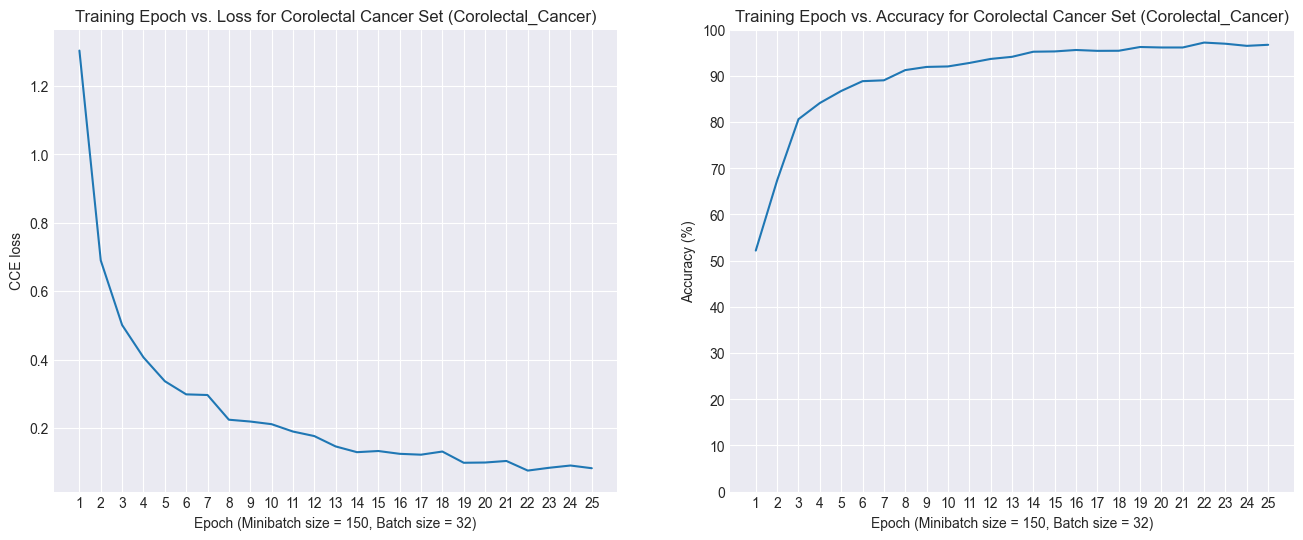

[INFO] Finished training w/SGD!


In [4]:
# Training loop for the model with SGD optimizer
print("[INFO] Starting training w/SGD... CHECK")

do_model_epoch_loop(resnet_corolectal_cancer_model, train_dataloader, 25, sgd_no_momentum, _device=device)

print("[INFO] Finished training w/SGD!")

[INFO] Begin inference on test set...
[INFO] Epoch 1/5, Loss: 0.0841, Accuracy: 97.2039%
[INFO] Epoch 2/5, Loss: 0.0852, Accuracy: 97.1217%
[INFO] Epoch 3/5, Loss: 0.0876, Accuracy: 97.0395%
[INFO] Epoch 4/5, Loss: 0.0870, Accuracy: 97.2039%
[INFO] Epoch 5/5, Loss: 0.0912, Accuracy: 97.0395%
[INFO] Epoch 6/5, Loss: 0.0832, Accuracy: 97.3684%
[INFO] Epoch 7/5, Loss: 0.0913, Accuracy: 96.7105%
[INFO] Epoch 8/5, Loss: 0.0887, Accuracy: 96.9572%
[INFO] Epoch 9/5, Loss: 0.0901, Accuracy: 96.7928%
[INFO] Epoch 10/5, Loss: 0.0825, Accuracy: 97.1217%


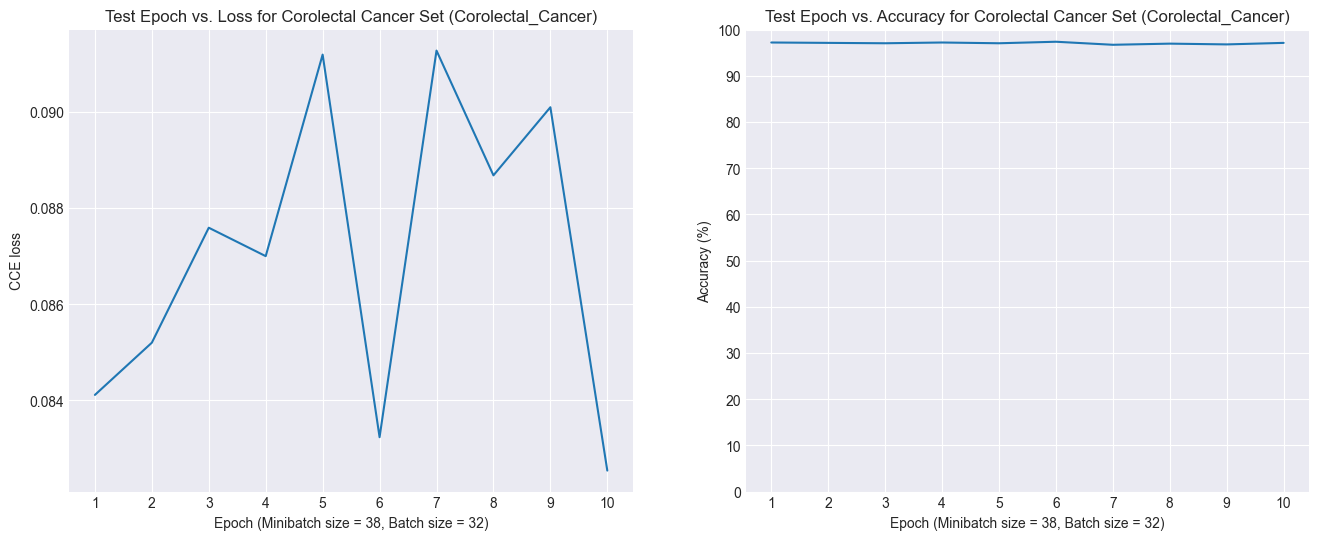

[INFO] Saved the pre-trained model!
[INFO] Finished training w/SGD !


In [ ]:
# Test set inference for SGD optimizer
print("[INFO] Begin inference on test set...")

do_model_epoch_loop(resnet_corolectal_cancer_model, test_dataloader, 10, sgd_no_momentum, _is_training=False, _device=device)

print("[INFO] Finished training w/SGD !")